In [72]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import norm
from io_utils import load_models, load_matrices_from_dir

In [74]:
test_data_sizes = {
    "bcsstk18": 1000,
    "cbuckle": 1000,
    "ct20stif": 1000,
    "raefsky4": 1000,
    "vanbody": 100
}

matrix = "vanbody"
df = pd.read_csv(f"data/{matrix}_{test_data_sizes[matrix]}.csv")
errorfree_iterations = df["errorfree_iterations"][0]  # all the same
n_rows = df["n_rows"][0]  # all the same
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,vanbody.mat,491,0.000001,49100,35528,74,49099,1.915060e-05,False,246.083343,1.511085e+05,47072,99.997963
1,vanbody.mat,491,0.000001,49100,37556,139,49099,4.618660e-06,False,246.444212,3.650676e+05,47072,99.997963
2,vanbody.mat,491,0.000001,49100,38358,193,49099,3.148359e-05,False,246.087799,8.792099e+05,47072,99.997963
3,vanbody.mat,491,0.000001,49100,46845,122,49099,6.786779e-05,False,246.800207,5.503797e+06,47072,99.997963
4,vanbody.mat,491,0.000001,49100,11088,312,32222,9.504907e-07,True,162.786341,7.860428e+04,47072,65.625255


In [75]:
chosen_models = {
    "bcsstk18": "RandomForestRegressor",
    "cbuckle": "KNeighborsRegressor",
    "ct20stif": "XGBRegressor",
    "raefsky4": "RandomForestRegressor",
    "vanbody": "RandomForestRegressor",
}
model_path = f"./models/{matrix}/best_{chosen_models[matrix]}.pkl"
model = load_models([model_path])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=4, n_estimators=50))])

In [76]:
X = df[["error_iter", "pos_2norm"]].to_numpy()
df["prot_score"] = model.predict(X)
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown,prot_score
0,vanbody.mat,491,0.000001,49100,35528,74,49099,1.915060e-05,False,246.083343,1.511085e+05,47072,99.997963,86.708153
1,vanbody.mat,491,0.000001,49100,37556,139,49099,4.618660e-06,False,246.444212,3.650676e+05,47072,99.997963,96.360158
2,vanbody.mat,491,0.000001,49100,38358,193,49099,3.148359e-05,False,246.087799,8.792099e+05,47072,99.997963,99.492006
3,vanbody.mat,491,0.000001,49100,46845,122,49099,6.786779e-05,False,246.800207,5.503797e+06,47072,99.997963,99.180526
4,vanbody.mat,491,0.000001,49100,11088,312,32222,9.504907e-07,True,162.786341,7.860428e+04,47072,65.625255,88.074926


In [77]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<47072x47072 sparse matrix of type '<class 'numpy.float64'>'
	with 2329056 stored elements in Compressed Sparse Column format>

In [78]:
pos_2norms = {pos: norm(mat.getrow(pos)) for pos in range(mat.shape[0])}
iter_norm_pairs = np.array([[i, pos_2norms[pos], pos] for pos in range(mat.shape[0])
                            for i in range(errorfree_iterations)])
df_preds = pd.DataFrame(iter_norm_pairs, columns=["i", "2norm", "rowid"])
df_preds["output"] = model.predict(df_preds[["i", "2norm"]].to_numpy())
df_preds_piv = df_preds.pivot(index=["2norm", "rowid"], columns="i", values="output")
prot_scores = df_preds_piv.to_numpy().T
df_preds_piv.head()

,i,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,481.0,482.0,483.0,484.0,485.0,486.0,487.0,488.0,489.0,490.0
2norm,rowid,,,,,,,,,,,,,,,,,,,,,
6.038983,29381.0,8.418773,8.418773,8.418773,8.426635,8.426635,8.426635,8.426635,9.051348,9.051348,9.051348,...,9.999913,9.999913,11.049458,11.049458,11.049458,12.500904,12.500904,12.500904,12.500904,12.500904
7.432166,5253.0,8.418773,8.418773,8.418773,8.426635,8.426635,8.426635,8.426635,9.051348,9.051348,9.051348,...,9.999913,9.999913,11.049458,11.049458,11.049458,12.500904,12.500904,12.500904,12.500904,12.500904
8.819495,42024.0,8.418773,8.418773,8.418773,8.426635,8.426635,8.426635,8.426635,9.051348,9.051348,9.051348,...,9.999913,9.999913,11.049458,11.049458,11.049458,12.500904,12.500904,12.500904,12.500904,12.500904
9.207319,4125.0,8.418773,8.418773,8.418773,8.426635,8.426635,8.426635,8.426635,9.051348,9.051348,9.051348,...,9.999913,9.999913,11.049458,11.049458,11.049458,12.500904,12.500904,12.500904,12.500904,12.500904
23.405054,29363.0,8.418773,8.418773,8.418773,8.426635,8.426635,8.426635,8.426635,9.051348,9.051348,9.051348,...,9.999913,9.999913,11.049458,11.049458,11.049458,12.500904,12.500904,12.500904,12.500904,12.500904


In [79]:
ps = list(np.arange(1 / 98, 1.01, 0.01))
percentages = np.arange(0.01, 1.0, 0.01)
nonerror_runs_by_p = {p: int((len(df) / p) - len(df)) for p in ps}
max_nonerror_runs = int((len(df) / min(ps)) - len(df))
solve_iterations = np.append(df["solve_iterations"], [errorfree_iterations] * max_nonerror_runs)
slowdowns = np.append(df["slowdown"], [1] * max_nonerror_runs)
errorfree_op_count = errorfree_iterations * n_rows

In [80]:
def compute_overheads(error_iterations, n_protections):
    return ((error_iterations * n_rows + n_protections) - errorfree_op_count) / errorfree_op_count

def protect(error_iterations, protections):
    return np.vectorize(lambda i: error_iterations[i] if not protections[i]
                        else errorfree_iterations)(range(len(error_iterations)))

def make_p_overhead_dataframe(ohs_by_p):
    return pd.concat([pd.DataFrame({"p": [ps[i]] * len(os), "overhead": os})
                         for i, os in enumerate(ohs_by_p)], ignore_index=True)

In [81]:
nonprot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    nonprot_overheads = compute_overheads(solve_iterations[:data_size], 0)
    nonprot_overheads_by_p.append(nonprot_overheads)

nonprot_df = make_p_overhead_dataframe(nonprot_overheads_by_p)

In [82]:
prot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    # for the purpose of choosing solve_iterations or errorfree_iterations, did_protect will
    # always be False for nonerror runs, but this is fine because n_protections is computed
    # later for the purposes of calculating overhead
    protections = np.append(df["prot_score"] > (1 + (1 / p)), [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = (prot_scores > (1 + (1 / p))).sum()

    prot_overheads = compute_overheads(prot_iterations, n_protections)
    prot_overheads_by_p.append(prot_overheads)

prot_df = make_p_overhead_dataframe(prot_overheads_by_p)

In [83]:
random_overheads = []
for perc in percentages:
    protections = np.random.rand(len(df)) < perc
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = int(errorfree_iterations * n_rows * perc)
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    random_overheads.append(prot_overheads.mean())
    
best_random_percentage = percentages[np.argmin(random_overheads)]
rand_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    protections = np.random.rand(data_size) < best_random_percentage

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = int(errorfree_iterations * n_rows * best_random_percentage)
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    rand_overheads_by_p.append(prot_overheads)

rand_df = make_p_overhead_dataframe(rand_overheads_by_p)

In [84]:
r2ns = np.array(list(pos_2norms.values()))
r2n_overheads = []
for perc in percentages:
    cutoff = np.quantile(r2ns, 1 - perc)
    protections = df["pos_2norm"] >= cutoff
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads.append(prot_overheads.mean())

best_r2n_percentage = percentages[np.argmin(r2n_overheads)]
cutoff = np.quantile(r2ns, 1 - best_r2n_percentage)
r2n_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    protections = np.append(df["pos_2norm"] >= cutoff, [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads_by_p.append(prot_overheads)

r2n_df = make_p_overhead_dataframe(r2n_overheads_by_p)

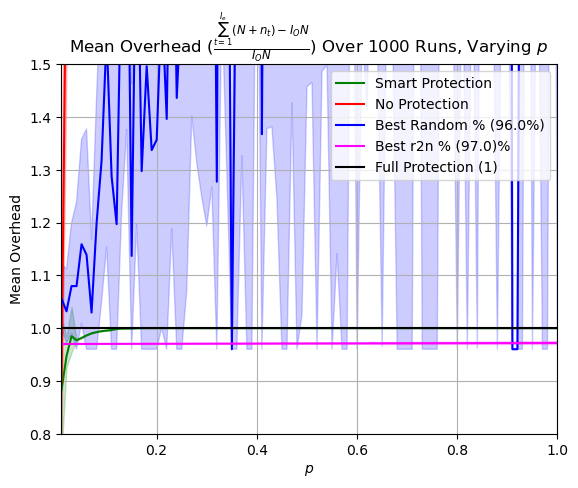

In [89]:
sns.lineplot(prot_df, x="p", y="overhead",
         label="Smart Protection", c="green")
sns.lineplot(nonprot_df, x="p", y="overhead",
             label="No Protection", c="red")
sns.lineplot(rand_df, x="p", y="overhead",
             label=f"Best Random % ({best_random_percentage * 100}%)", c="blue")
sns.lineplot(r2n_df, x="p", y="overhead",
             label=f"Best r2n % ({best_r2n_percentage * 100})%", c="magenta")
plt.plot(ps, [1] * len(ps), label="Full Protection (1)", c="black")

plt.xlabel("$p$")
plt.ylabel("Mean Overhead")
overhead_formula = r"$ \frac{\sum_{t=1}^{I_e}(N + n_t) - I_ON}{I_ON} $"
plt.title(f"Mean Overhead ({overhead_formula}) Over 1000 Runs, Varying $p$ ")
plt.legend()
plt.grid()
plt.xlim(0.01, 1)
plt.ylim(0.8, 1.5)
plt.savefig(f"./figures/{matrix}/mean_overheads.png")
plt.show()

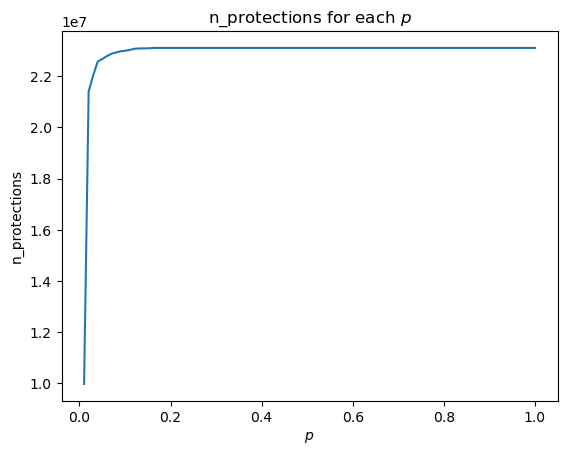

In [86]:
n_prots_per_p = []

for p in ps:
    protections = prot_scores > (1 + (1 / p))
    n_prots_per_p.append(protections.sum())

s = pd.Series(n_prots_per_p)
plt.plot(ps, s)
plt.title("n_protections for each $p$")
plt.xlabel("$p$")
plt.ylabel("n_protections")
plt.show()